## Pizza vs Ice Cream
Dataset: https://www.kaggle.com/datasets/hemendrasr/pizza-vs-ice-cream

## Import Library

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


## Load Data

In [6]:
TRAIN_DIR = './data/train'
VAL_DIR = './data/valid'
TEST_DIR = './data/test'

In [7]:
BATCH_SIZE=32
IMG_SIZE = 480

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 718 images belonging to 2 classes.


In [9]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 208 images belonging to 2 classes.


In [10]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 106 images belonging to 2 classes.


## Data Visualization

### Utils

In [11]:
def plot_grid_images(images, labels, columns=5, image_size=None, figsize=(8, 8), cmap='gray', title=None, file_name=None):
    fig = plt.figure(figsize=figsize)
    fig.tight_layout(h_pad=3)
    rows = math.ceil(len(images)/columns)
    for image, label, position in zip(images, labels, range(1, len(labels)+1)):
        fig.add_subplot(rows, columns, position)
        if image_size is not None:
            image = image.reshape(image_size)

        plt.imshow(image, cmap=cmap, interpolation='nearest')
        plt.axis('off')
        plt.title(label)
    if title is not None:
        fig.suptitle(title, fontsize=14)

    if file_name is not None:
        plt.savefig(file_name)
    plt.show()
    return file_name


def show_examples(generator, no_labels=False, title=None, no_images_to_show=9, columns=3):
    images_to_show = []
    images_labels = []
    images_shape = None
    
    if no_labels:
        for images in generator:
            images_shape = images.shape[1:]
            images_to_show.extend(images)
            if len(images_to_show) >= no_images_to_show:
                break
        images_labels = [None for _ in range(no_images_to_show)]
    else:
        class_indices = {index: label for label, index in generator.class_indices.items()}
        for images, labels in generator:
            images_shape = images.shape[1:]
            images_to_show.extend(images)
            images_labels.extend([class_indices[index] for index in labels])
            if len(images_to_show) >= no_images_to_show:
                break
    
    print('IMAGE SHAPE: ', images_shape)
    plot_grid_images(images_to_show[:no_images_to_show], images_labels[:no_images_to_show], title=title, columns=columns)

### Train Images

IMAGE SHAPE:  (480, 480, 3)


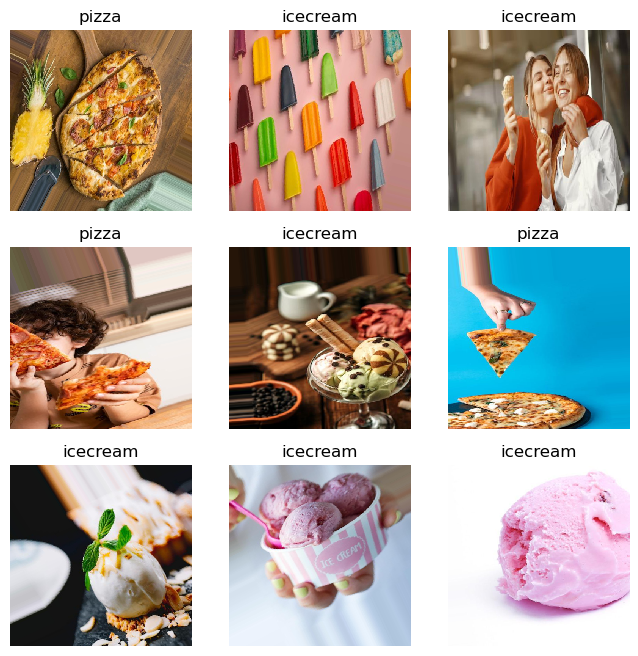

In [12]:
show_examples(train_generator)

### Validation Images

IMAGE SHAPE:  (480, 480, 3)


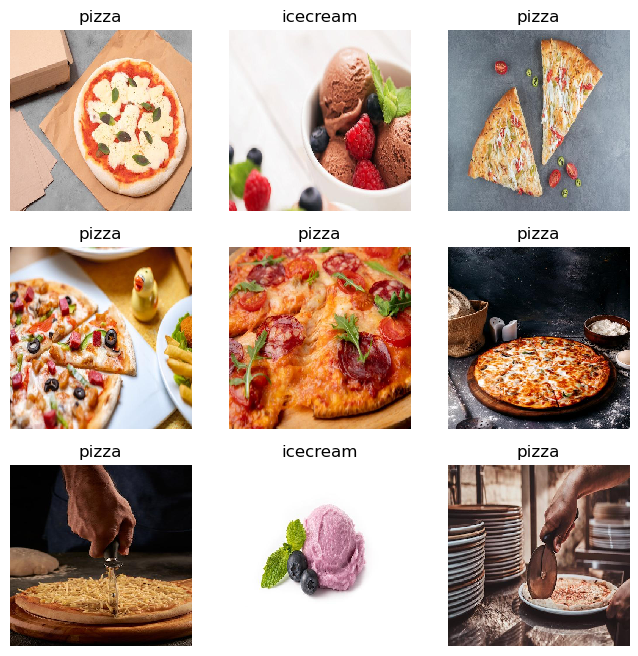

In [13]:
show_examples(val_generator)

### Test Images

IMAGE SHAPE:  (480, 480, 3)


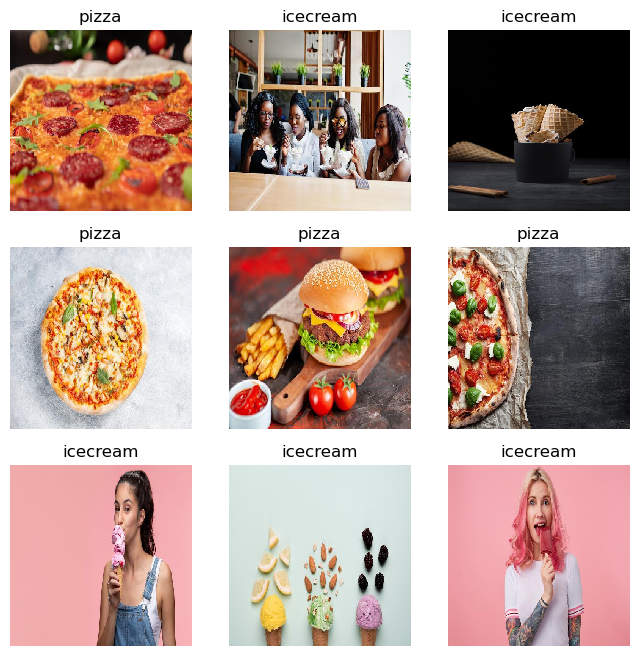

In [14]:
show_examples(test_generator)

## Model

In [15]:
FEATURE_EXTRACTOR_URL = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2'
# FEATURE_EXTRACTOR_URL = 'https://tfhub.dev/tensorflow/efficientnet/b6/classification/1'

In [16]:
model = tf.keras.Sequential([
    hub.KerasLayer(FEATURE_EXTRACTOR_URL, trainable=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-09-13 01:23:19.234217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-13 01:23:19.234347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              53150388  
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 53,152,950
Trainable params: 2,562
Non-trainable params: 53,150,388
_________________________________________________________________


## Model Train

In [2]:
SAVED_MODEL_PATH = './models/pizza_vs_icecream_model.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[model_checkpoint, early_stopping],
    verbose=2
)

Epoch 1/50


2022-09-13 01:23:54.663893: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-13 01:24:03.973096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-13 01:24:34.109384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 - 52s - loss: 0.3017 - accuracy: 0.8900 - val_loss: 0.0705 - val_accuracy: 0.9952 - 52s/epoch - 2s/step
Epoch 2/50
23/23 - 35s - loss: 0.0480 - accuracy: 0.9903 - val_loss: 0.0363 - val_accuracy: 0.9952 - 35s/epoch - 2s/step
Epoch 3/50
23/23 - 35s - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0221 - val_accuracy: 1.0000 - 35s/epoch - 2s/step
Epoch 4/50
23/23 - 35s - loss: 0.0254 - accuracy: 0.9958 - val_loss: 0.0164 - val_accuracy: 1.0000 - 35s/epoch - 2s/step
Epoch 5/50
23/23 - 35s - loss: 0.0204 - accuracy: 0.9958 - val_loss: 0.0125 - val_accuracy: 1.0000 - 35s/epoch - 2s/step
Epoch 6/50
23/23 - 35s - loss: 0.0151 - accuracy: 0.9972 - val_loss: 0.0113 - val_accuracy: 1.0000 - 35s/epoch - 2s/step
Epoch 7/50
23/23 - 35s - loss: 0.0123 - accuracy: 0.9986 - val_loss: 0.0090 - val_accuracy: 1.0000 - 35s/epoch - 2s/step
Epoch 8/50
23/23 - 35s - loss: 0.0143 - accuracy: 0.9972 - val_loss: 0.0084 - val_accuracy: 1.0000 - 35s/epoch - 2s/step
Epoch 9/50
23/23 - 35s - loss: 0.0101 - acc

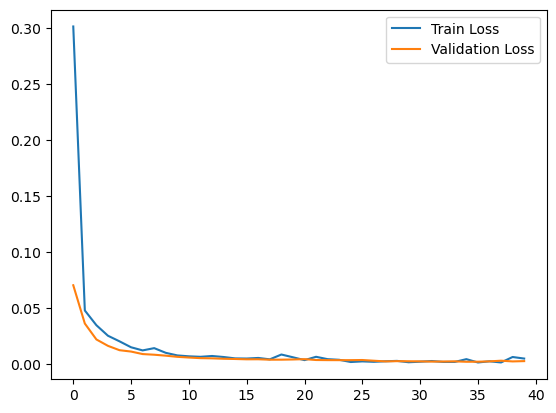

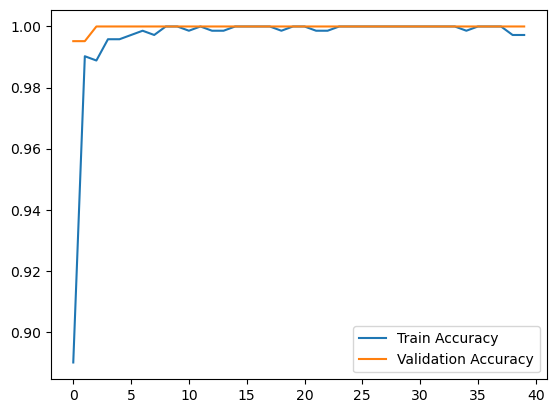

In [19]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [3]:
saved_model = tf.keras.models.load_model(
    SAVED_MODEL_PATH,
    custom_objects={'KerasLayer': hub.KerasLayer}
)

2022-09-13 02:07:47.941205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-13 02:07:47.941322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [15]:
saved_model.evaluate(test_generator)

2022-09-13 02:09:25.833769: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-13 02:09:26.285479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 7s 1s/step - loss: 0.0043 - accuracy: 1.0000


[0.004329057410359383, 1.0]

## Conclusion

Now as the model is performing quite good on the test records. We will deploy it using Flask and use the APIs in the streamlit app for web app.